## Spark Machine Learning Libary

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

appName = "Big Data Analytics"
master = "local"

# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
.set('spark.driver.host','127.0.0.1')\
.setAppName(appName)\
.setMaster(master)

# Create Spark Context 
sc = SparkContext.getOrCreate(conf=conf)

# Create SQL Context to conduct some database operations
sqlContext = SQLContext(sc)

# If you have SQL context, you create the session from the Spark Context
spark = sqlContext.sparkSession.builder\
.config("spark.jars.packages", "org.postgresql:postgresql:42.2.29") \
.config("spark.sql.execution.arrow.enabled","true")\
.getOrCreate() 

24/10/13 21:47:16 WARN Utils: Your hostname, Kitiyas-MacBook-Air-5.local resolves to a loopback address: 127.0.0.1; using 10.0.0.202 instead (on interface en0)
24/10/13 21:47:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/13 21:47:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/10/13 21:47:18 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/10/13 21:47:18 WARN SparkSession: Using an existing Spark session; only runtime S

**Load the dataset from Postgres**

In [40]:
# Connect to dataset in Postgres table
db_properties={}
db_properties['username']="postgres" 
db_properties['password']=""
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "NSLKDD"

# Read dataset
postgresDB = spark.read \
    .format("jdbc") \
    .option("url", db_properties['url']) \
    .option("dbtable", db_properties['table']) \
    .option("user", db_properties['username']) \
    .option("password", db_properties['password']) \
    .option("driver", db_properties['driver']) \
    .load()

postgresDB.show(3, vertical=True)

-RECORD 0-------------------------------
 duration                    | 0        
 protocol_type               | tcp      
 service                     | ftp_data 
 flag                        | SF       
 src_bytes                   | 491      
 dst_bytes                   | 0        
 land                        | 0        
 wrong_fragment              | 0        
 urgent                      | 0        
 hot                         | 0        
 num_failed_logins           | 0        
 logged_in                   | 0        
 num_compromised             | 0        
 root_shell                  | 0        
 su_attempted                | 0        
 num_root                    | 0        
 num_file_creations          | 0        
 num_shells                  | 0        
 num_access_files            | 0        
 num_outbound_cmds           | 0        
 is_host_login               | 0        
 is_guest_login              | 0        
 count                       | 2        
 srv_count      

In [3]:
# Split train and test dataset
nslkdd_raw = postgresDB.filter("data_type == 'train'")
nslkdd_test_raw = postgresDB.filter("data_type == 'test'")

In [4]:
# Check existed column names to adjust columns in the pipeline
nslkdd_raw.columns

['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'classes',
 'difficulty_level',
 'data_type']

### Q1

**Create a single pipline that conducts data engineering, data preprocessing, and machine learning models**

In [19]:
nominal_cols = ['protocol_type','service','flag']
binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login',
'is_guest_login']
continuous_cols = ['duration' ,'src_bytes', 'dst_bytes', 'wrong_fragment' ,'urgent', 'hot',
'num_failed_logins', 'num_compromised', 'num_root' ,'num_file_creations',
'num_shells', 'num_access_files', 'num_outbound_cmds', 'count' ,'srv_count',
'serror_rate', 'srv_serror_rate' ,'rerror_rate' ,'srv_rerror_rate',
'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate' ,'dst_host_count',
'dst_host_srv_count' ,'dst_host_same_srv_rate' ,'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate' ,'dst_host_srv_diff_host_rate',
'dst_host_serror_rate' ,'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        label_to_binary = udf(lambda name: 0.0 if name == 'normal' else 1.0)
        output_df = dataset.withColumn('outcome', label_to_binary(col('classes'))).drop("classes")  
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        output_df = output_df.drop('difficulty_level')
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
    
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df
    
def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                     "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    

    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'] + ['data_type'])
    
    # Init Logistic Regression Model
    stage_machine_learning = LogisticRegression(featuresCol = 'features', labelCol = 'outcome')
    
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper,stage_machine_learning])
    return pipeline 

In [20]:
# Fit the pipeline with training set
preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(nslkdd_raw)

# Transform the pipeline with test set
predictions = preprocess_pipeline_model.transform(nslkdd_test_raw)

24/10/13 21:54:37 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/10/13 21:54:38 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


In [21]:
# Print the schema and results
predictions.printSchema()
predictions.select("rawPrediction","probability","prediction","outcome").toPandas().head()


root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



,rawPrediction,probability,prediction,outcome
0,"[-8.500875764495945, 8.500875764495945]","[0.000203248938111855, 0.9997967510618881]",1.0,1.0
1,"[-6.916044525123291, 6.916044525123291]","[0.000990762431225992, 0.999009237568774]",1.0,1.0
2,"[3.445817242176555, -3.445817242176555]","[0.9691061567462618, 0.03089384325373823]",0.0,0.0
3,"[-3.410413288182366, 3.410413288182366]","[0.03197160398530648, 0.9680283960146935]",1.0,1.0
4,"[3.2708003605798313, -3.2708003605798313]","[0.9634133933225713, 0.036586606677428746]",0.0,1.0


Refer to q1.png

### Q2

**Multi-Class Classification. In this question, you will use sparkML to predict not just
whether there is an attack, but also the type of the attack. In other words, this is a multi-class
classification problem with 5 possible categories (normal, DOS, R2L, U2R, probing)**

#### Q2-1

Create a preprocess pipeline that conducts the usual data engineering steps
(as in the lecture), and also create an outcome column that indicates which of the 5 categories the record belongs to

In [39]:
nslkdd_raw.withColumn('classes',col('classes')).groupBy('classes').count().show(vertical=True)

-RECORD 0------------------
 classes | neptune         
 count   | 41214           
-RECORD 1------------------
 classes | satan           
 count   | 3633            
-RECORD 2------------------
 classes | nmap            
 count   | 1493            
-RECORD 3------------------
 classes | portsweep       
 count   | 2931            
-RECORD 4------------------
 classes | back            
 count   | 956             
-RECORD 5------------------
 classes | warezclient     
 count   | 890             
-RECORD 6------------------
 classes | guess_passwd    
 count   | 53              
-RECORD 7------------------
 classes | normal          
 count   | 67343           
-RECORD 8------------------
 classes | rootkit         
 count   | 10              
-RECORD 9------------------
 classes | perl            
 count   | 3               
-RECORD 10-----------------
 classes | buffer_overflow 
 count   | 30              
-RECORD 11-----------------
 classes | multihop        
 count   | 7        

In [29]:
from pyspark.sql.types import IntegerType

nominal_cols = ['protocol_type','service','flag']
binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login',
'is_guest_login']
continuous_cols = ['duration' ,'src_bytes', 'dst_bytes', 'wrong_fragment' ,'urgent', 'hot',
'num_failed_logins', 'num_compromised', 'num_root' ,'num_file_creations',
'num_shells', 'num_access_files', 'num_outbound_cmds', 'count' ,'srv_count',
'serror_rate', 'srv_serror_rate' ,'rerror_rate' ,'srv_rerror_rate',
'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate' ,'dst_host_count',
'dst_host_srv_count' ,'dst_host_same_srv_rate' ,'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate' ,'dst_host_srv_diff_host_rate',
'dst_host_serror_rate' ,'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        def attack_category(attack_type):
            if attack_type == 'normal':
                return 0
            elif attack_type in ['port-Sweep', 'ip-Sweep', 'nmap', 'satan', 'saint', 'mscan']:
                return 1  # Probing
            elif attack_type in ['neptune', 'smurf', 'pod', 'teardrop', 'land', 'back', 'apache2',
                                'udpstorm', 'processtable', 'mail-Bomb']:
                return 2  # Dos
            elif attack_type in ['buffer-Overflow', 'load-Module', 'perl', 'rootkit', 'xterm',
                                'ps', 'sqlattack']:
                return 3  # U2R
            else:
                return 4  # R2L
          
        # Convert the function to a UDF, specifying IntegerType for output
        label_to_multiclasses = udf(attack_category, IntegerType())
        output_df = dataset.withColumn('outcome', label_to_multiclasses(col('classes'))).drop("classes")  
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        output_df = output_df.drop('difficulty_level')
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
    
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df
    
def get_preprocess_muticlass_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                     "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    

    # Stage for creating the outcome column representing whether there is normal, DOS, R2L, U2R, probing.
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'] + ['data_type'])
    
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    return pipeline 

In [38]:
preprocess_multi_class_pipeline = get_preprocess_muticlass_pipeline()
preprocess_multi_class = preprocess_multi_class_pipeline.fit(nslkdd_raw)

# Trandform train dataset
nslkdd_multi = preprocess_multi_class.transform(nslkdd_raw)
nslkdd_multi.show(3, vertical=True)

-RECORD 0------------------------
 features | (113,[1,13,14,17,... 
 outcome  | 0.0                  
-RECORD 1------------------------
 features | (113,[1,13,14,17,... 
 outcome  | 0.0                  
-RECORD 2------------------------
 features | (113,[13,14,15,17... 
 outcome  | 2.0                  
only showing top 3 rows



In [37]:
# Trandform test datset 
nslkdd_test_multi = preprocess_multi_class.transform(nslkdd_test_raw)
nslkdd_test_multi.show(3, vertical=True)

-RECORD 0------------------------
 features | (113,[13,14,16,17... 
 outcome  | 2.0                  
-RECORD 1------------------------
 features | (113,[13,14,16,17... 
 outcome  | 2.0                  
-RECORD 2------------------------
 features | (113,[0,1,13,14,1... 
 outcome  | 0.0                  
only showing top 3 rows



#### Q2-2

Select 2 machine learning models. For each of the machine learning models,
train it on the training dataset. Calculate the train and test accuracy, and plot the
confusion matrix (for the predictions on the test dataset).

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

class_names=[0.0, 1.0, 2.0, 3.0, 4.0]
class_names_str=["normal","probing", "Dos", "U2R", "R2L"]

def plot_confusion_matrix(cm, classes=class_names_str,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Logistic Regression**

In [75]:
from pyspark.ml.classification import LogisticRegression

# Create a logistic regression model
lr = LogisticRegression(featuresCol = 'features', 
                             labelCol = 'outcome', 
                             maxIter=10)

# Fit the model
lrModel = lr.fit(nslkdd_multi)

# Calculate a train accuracy
predictions_train = lrModel.transform(nslkdd_multi)
accuracy_train = (predictions_train.filter(predictions_train.outcome == predictions_train.prediction)
    .count() / float(predictions_train.count()))
# Calculate a test accuracy
lr_predictions_test = lrModel.transform(nslkdd_test_multi)
accuracy_test = (lr_predictions_test.filter(lr_predictions_test.outcome == lr_predictions_test.prediction)
    .count() / float(lr_predictions_test.count()))

print(f"Train Accuracy : {np.round(accuracy_train*100,2)}%")
print(f"Test Accuracy : {np.round(accuracy_test*100,2)}%")

24/10/14 16:00:51 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/10/14 16:00:51 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


Train Accuracy : 96.98%
Test Accuracy : 71.9%


In [76]:
# Sample of prediction on test dataset
lr_predictions_test.show(1, vertical=True)

-RECORD 0-----------------------------
 features      | (113,[13,14,16,17... 
 outcome       | 2.0                  
 rawPrediction | [-1.9937692626270... 
 probability   | [3.03139767540605... 
 prediction    | 2.0                  
only showing top 1 row



Confusion matrix, without normalization
[[8986  590   83    0   52]
 [ 637 1182  152    0  152]
 [1076    6 5574    0  509]
 [  35    0    0    8    2]
 [3028    4    5    3  460]]


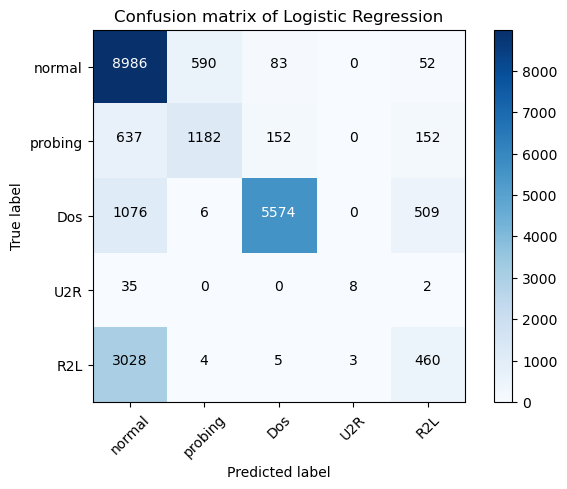

In [77]:
# Plot a confusion matrix of test prediction
outcome_true = lr_predictions_test.select("outcome")
outcome_true = outcome_true.toPandas()

pred = lr_predictions_test.select("prediction")
pred = pred.toPandas()

cnf_matrix = confusion_matrix(outcome_true, pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names_str,
                      title='Confusion matrix of Logistic Regression')
plt.show()

**Decision Tree**

In [78]:
from pyspark.ml.classification import DecisionTreeClassifier

# Create a decision tree model
dt = DecisionTreeClassifier(featuresCol = 'features', 
                             labelCol = 'outcome', 
                             maxDepth=7)
# Fit the model
dtModel = dt.fit(nslkdd_multi)

# Calculate a train accuracy
predictions_train = dtModel.transform(nslkdd_multi)
accuracy_train = (predictions_train.filter(predictions_train.outcome == predictions_train.prediction)
    .count() / float(predictions_train.count()))
# Calculate a test accuracy
dt_predictions_test = dtModel.transform(nslkdd_test_multi)
accuracy_test = (dt_predictions_test.filter(dt_predictions_test.outcome == dt_predictions_test.prediction)
    .count() / float(dt_predictions_test.count()))

print(f"Train Accuracy : {np.round(accuracy_train*100,2)}%")
print(f"Test Accuracy : {np.round(accuracy_test*100,2)}%")

24/10/14 16:00:55 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/10/14 16:00:55 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/10/14 16:00:56 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/10/14 16:00:57 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


Train Accuracy : 99.0%
Test Accuracy : 73.24%


In [79]:
# Sample of prediction on test dataset
dt_predictions_test.show(1, vertical=True)

-RECORD 0-----------------------------
 features      | (113,[13,14,16,17... 
 outcome       | 2.0                  
 rawPrediction | [13.0,34.0,40784.... 
 probability   | [3.18151782873644... 
 prediction    | 2.0                  
only showing top 1 row



Confusion matrix, without normalization
[[9439  147   67    0   58]
 [ 668 1005  240    0  210]
 [1613   18 5526    0    8]
 [  40    2    0    0    3]
 [2946   12    0    0  542]]


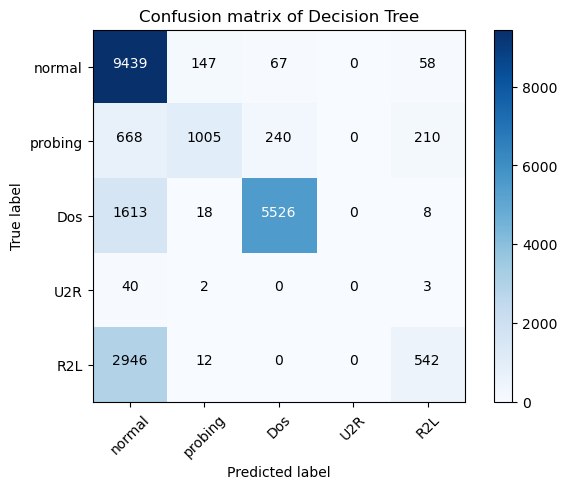

In [80]:
# Plot a confusion matrix of test prediction
outcome_true = dt_predictions_test.select("outcome")
outcome_true = outcome_true.toPandas()

pred = dt_predictions_test.select("prediction")
pred = pred.toPandas()

cnf_matrix = confusion_matrix(outcome_true, pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names_str,
                      title='Confusion matrix of Decision Tree')
plt.show()

#### Q2-3

For each of the 2 machine learning models, identify at least one hyper
parameter, build a parameter grid and conduct hyper-parameter tuning using cross-
validation, with accuracy as the metric. Calculate the test accuracy after tuning. (Hint:
for evaluating accuracy, the you may need to find the appropriate Evaluator with the
appropriate metric name).

**Logistic Regression**

In [81]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
lr_paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.0, 0.5])
             .addGrid(lr.maxIter, [5, 10, 15])
             .build())

# Create multiclass evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="outcome", predictionCol="prediction", metricName="accuracy")

# Create cross-validation tuning
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_paramGrid, 
                    evaluator=evaluator, numFolds=5)

# Fit the cross-validation with train dataset
lr_cv_model = lr_cv.fit(nslkdd_multi)


24/10/14 16:01:20 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/10/14 16:01:20 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/10/14 16:01:21 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/10/14 16:01:21 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/10/14 16:01:22 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

In [82]:
# Transform the cross-validation with test dataset
lr_cv_prediction_test = lr_cv_model.transform(nslkdd_test_multi)
print('Test accuracy after Cross-Validation:', evaluator.evaluate(lr_cv_prediction_test))
print('Test accuracy before Cross-Validation:', evaluator.evaluate(lr_predictions_test))

24/10/14 16:02:07 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


Test accuracy after Cross-Validation: 0.73833392476934
Test accuracy before Cross-Validation: 0.7190383250532293


24/10/14 16:02:07 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


**Decision Tree**

In [83]:
# Create ParamGrid for Cross Validation
dt_paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [5, 7, 9])
             .build())

# Create multiclass evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="outcome", predictionCol="prediction", metricName="accuracy")

# Create cross-validation tuning
dt_cv = CrossValidator(estimator=dt, estimatorParamMaps=dt_paramGrid, 
                    evaluator=evaluator, numFolds=5)

# Fit the cross-validation with train dataset
dt_cv_model = dt_cv.fit(nslkdd_multi)

24/10/14 16:02:21 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/10/14 16:02:21 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/10/14 16:02:21 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/10/14 16:02:21 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/10/14 16:02:21 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

In [84]:
# Transform the cross-validation with test dataset
dt_cv_prediction_test = dt_cv_model.transform(nslkdd_test_multi)
print('Test accuracy after Cross-Validation:', evaluator.evaluate(dt_cv_prediction_test))
print('Test accuracy before Cross-Validation:', evaluator.evaluate(dt_predictions_test))

24/10/14 16:03:19 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


Test accuracy after Cross-Validation: 0.7394872249822569
Test accuracy before Cross-Validation: 0.7324343506032647


24/10/14 16:03:20 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


#### Q2-4

In your own words, explain why you chose the two machine learning models,
and for each of the two models, why you chose the hyper-parameter(s) to tune, and
how you designed the parameter grid. Also, please include a discussion on the
comparison of the two models.

**Report of Experiments**

Logistic Regression is a model that ables binary and multi-class classification as well as Decision Tree but they have different classifier methods. 

From training with logistic regression in Q2-2, I set up maxIter params as 10 as a significant hyper-parameter for logistic regression model resulting in not good accuracy so I created a paramgrid to explore more on maxIter and regParam values;decreasing and increasing maxIter values from the Q2-2 initial, increase regParam values to verify their effect on training muti-class classifier. Thus, they help to increse accuracy for 2%.

The importance hyper-parameter of decision tree is maxDepth. I inited it as 7 (initial values)in Q2-2 and do experiment with reducing to 5 and increasing to 9 led to slightly grow up of accuracy around 0.07%.

Therefore, Decision Tree model gived more accuracy than Logistic Regression with 73.95% and 73.83% respectively.

#### Q2-5

Pick one of the two ML models and run the training process (don't need to
do hyper-parameter tuning) on the google cloud DataProc cluster in cluster mode. Show
a screenshot of the spark history server, including the Jobs page and the Executor page

Refer to q2-5_1.png, q2-5_2.png, q2-5_3.png, q2-5_4.png

#### Q2-6

Continuing from Q2-5, on the DataProc cluster, pick a dataframe and show
how many partitions the underlying RDD has.

Refer to q2-6.png

*citation*

- Classification and regression - Spark 3.5.3 Documentation. (n.d.). https://spark.apache.org/docs/latest/ml-classification-regression.html#one-vs-rest-classifier-aka-one-vs-all
- lecture 8: sparkML_training_evaluation_code.ipynb
- lecture 9: sparkML_hyper_parameter_tuning_code.ipynb
- lecture 10: sparkML_cloud_code.ipynb